# Relatório do Projeto Final

## Machine Learning - 2023.1

### Autores: Marco Moliterno e Renato Falcão

Este relatório apresenta um estudo de aplicação de técnicas de aprendizado de máquina para prever o preço de cartas do jogo Yu-Gi-Oh, baseando-se em uma série de características distintas. Para a realização deste trabalho, foi utilizado um dataset consolidado a partir da junção de dados obtidos na plataforma Kaggle e da API do website Yu-Gi-Oh Prices, fornecendo um amplo escopo de informações sobre as cartas, bem como seus preços médios. Este estudo visa explorar o potencial do aprendizado de máquina na interpretação e modelagem de padrões de preço no mercado de cartas colecionáveis, oferecendo insights valiosos para colecionadores e negociantes de cartas Yu-Gi-Oh. Os resultados obtidos neste estudo podem servir como base para futuras pesquisas e aplicações práticas, aprimorando a compreensão e previsão do mercado de cartas colecionáveis.

#### Referências

Base de dados do Kaggle disponível [aqui](https://www.kaggle.com/datasets/thedevastator/yu-gi-oh-dataset?select=yugioh_enriched.csv).

Requisições web realizadas ao iterar sobre os sets de cartas, obtendo os preços das cartas pertencentes aos respectivos sets. Esta API pode ser consumida pelo endpoint `https://yugiohprices.com/api/set_data/{nome_do_set}`. Exemplo de resposta pode ser observado [aqui](https://yugiohprices.com/api/set_data/2013%20Collectible%20Tins%20Wave%201).

# Inicio do projeto

## Importando bibliotecas e carregando base de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv("dbs/yugi_db_polished.csv", index_col=0)

df.head()

,Name,Rarity,Price,Description,CardType,Attribute,ATK,DEF,LVL,Property,MonsterType,isEffect,Duelist,Ability1,Ability2,isTuner,isPendulum
0,XX-Saber Boggart Knight,Shatterfoil Rare,2.73,When this card is Normal Summoned: You can Spe...,monster,earth,1900.0,1000.0,4.0,NaN,Beast-Warrior,Effect,NaN,NaN,NaN,NaN,NaN
1,Gagaga Cowboy,Shatterfoil Rare,4.68,2 Level 4 monsters\r\n\r\nOnce per turn: You c...,monster,earth,1500.0,2400.0,4.0,NaN,Warrior,Effect,NaN,Xyz,NaN,NaN,NaN
2,Forbidden Chalice,Shatterfoil Rare,2.09,Target 1 face-up monster on the field; until t...,spell,NaN,NaN,NaN,NaN,Quick-Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fairy Cheer Girl,Shatterfoil Rare,2.06,2 Level 4 Fairy-Type monsters\r\n\r\nYou can d...,monster,light,1900.0,1500.0,4.0,NaN,Fairy,Effect,NaN,Xyz,NaN,NaN,NaN
4,Exploder Dragon,Shatterfoil Rare,2.08,If this card is destroyed by battle and sent t...,monster,earth,1000.0,0.0,3.0,NaN,Dragon,Effect,NaN,NaN,NaN,NaN,NaN


## Análise Exploratória e Limpeza dos Dados

A partir desta base de dados, é possível começar o estudo realizando uma *análise exploratória*, na qual se deseja identificar as características do dataset, observando a estrutura dos dados disponíveis, presença de anomalias, tendências, padrões, distribuições e dados ausentes. O entendimento dos dados é fundamental para se poder tomar decisões com bom embasamento acerca da forma como o probelam será abordado.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11574 entries, 0 to 11573
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         11574 non-null  object 
 1   Rarity       11574 non-null  object 
 2   Price        11574 non-null  float64
 3   Description  11574 non-null  object 
 4   CardType     11574 non-null  object 
 5   Attribute    7470 non-null   object 
 6   ATK          7580 non-null   float64
 7   DEF          7580 non-null   float64
 8   LVL          7580 non-null   float64
 9   Property     4096 non-null   object 
 10  MonsterType  7478 non-null   object 
 11  isEffect     7478 non-null   object 
 12  Duelist      102 non-null    object 
 13  Ability1     1696 non-null   object 
 14  Ability2     137 non-null    object 
 15  isTuner      453 non-null    object 
 16  isPendulum   277 non-null    object 
dtypes: float64(4), object(13)
memory usage: 1.6+ MB


In [3]:
df.columns

Index(['Name', 'Rarity', 'Price', 'Description', 'CardType', 'Attribute',
       'ATK', 'DEF', 'LVL', 'Property', 'MonsterType', 'isEffect', 'Duelist',
       'Ability1', 'Ability2', 'isTuner', 'isPendulum'],
      dtype='object')

As variáveis que estão disponíveis na base de dados são as seguintes:

**Name**: O nome da carta. Cada carta de Yu-Gi-Oh tem um nome único que a distingue de outras cartas.

**Rarity**: Refere-se à raridade da carta. No geral, as cartas raras são mais difíceis de encontrar do que as comuns. Exemplos de raridades incluem "Common", "Rare", "Ultra Rare", "Secret Rare", entre outros.

**Price**: O preço de mercado da carta. Isso pode variar com base em vários fatores, como raridade, demanda, condição da carta e se ela está em circulação.

**Description**: O texto da carta, que descreve o seu efeito ou lore.

**CardType**: O tipo de carta. As cartas de Yu-Gi-Oh podem ser de vários tipos, como Monstros, Magias, ou Armadilhas.

**Attribute**: Uma caracteristica específica dos monstros. Existem 6 atributos principais: Luz, Trevas, Fogo, Água, Terra e Vento.

**ATK**: Abreviação de "Attack Points". Este é o poder de ataque de uma carta de monstro. Quando dois monstros em modo de ataque batalham, o monstro com o ATK mais alto geralmente destrói o monstro com o ATK mais baixo.

**DEF**: Abreviação de "Defense Points". Este é o poder de defesa de uma carta de monstro. É usado quando o monstro está em posição de defesa.

**LVL**: Abreviação de "Level". Este é o nível de uma carta de monstro. O nível de um monstro geralmente determina seu poder, e também é usado para o mecanismo de invocação de tributo. Um monstro level 4 ou menor pode ser invocado normalmente sem tributo, um monstro nível 5 ou 6 necessita um, e um monstro nível 7 ou maior necessíta dois.

**Property**: Este é um atributo de cartas de Magia e Armadilha. As propriedades de cartas de Magia incluem "Normal", "Contínua", "Equipamento", "Campo", "Rápida", etc. As cartas de Armadilha têm propriedades "Normal", "Contínua" e "Contra".

**MonsterType**: Isto é específico para cartas de monstros e refere-se à sua classificação. Exemplos incluem "Guerreiro", "Besta", "Dragão", "Demoníaco", etc.

**isEffect**: Um indicador de se o monstro é uma carta de Monstro de Efeito. Estes monstros têm habilidades especiais que são ativadas sob certas condições.

**Duelist**: Uma característica específica a cartas Skill. Indica o duelista que utiliza a carta. 

**Ability1** e **Ability2**: Estes se referem a habilidades especiais ou efeitos que a carta pode ter. Algumas cartas podem ter várias habilidades. Exemplos incluem 'Spirit', 'Gemini' e 'Toon'.

**isTuner**: Um indicador de se a carta é um Monstro Tuner. Estes monstros são usados para Invocações Synchro.

**isPendulum**: Um indicador de se a carta é um Monstro de Pêndulo. Estes monstros podem ser usados como mágias quando jogados nas Zonas de Pêndulo. Além disso, eles têm escalas de Pêndulo que permitem seu uso em Invocação por Pêndulo.

É possível notar que diversas colunas possuem uma grande quantidade de dados faltantes. No entanto, esses dados "faltantes" significam, na verdade, se as cartas possuem certos atributos ou não. Para analisar as características individuais de cada tipo de carta ("CardType"), podemos analisar um recorte de cada um dos tipos:

In [4]:
text_card_caracteristics = ["Name", "Description"]
categoric_card_caracteristics = ["CardType", "Rarity", "Attribute", "Property", "MonsterType", "Duelist", "Ability1", "Ability2"]
boolean_card_caracteristics = ["isEffect", "isTuner", "isPendulum"]
numeric_card_caracteristics = ["ATK", "DEF", "LVL", "Price"]

card_types = df["CardType"].unique()

bold = lambda word: f"\033[1m{word}\033[0m"
color = lambda word: f"\033[92m{word}\033[0m"

for card_type in card_types:
    print(f"{color('Card Type')}: \n{card_type}\n")
    recorte = df[df["CardType"] == card_type]
    for caracteristica in categoric_card_caracteristics[1:]:
        print(f"{bold(caracteristica)}: \n{recorte[caracteristica].unique()}\n")
    for caracteristica in boolean_card_caracteristics:
        print(f"{bold(caracteristica)}: \n{recorte[caracteristica].unique()}\n")
    for caracteristica in numeric_card_caracteristics:
        print(f"{bold(caracteristica)}: \n{recorte[caracteristica].describe()}\n")
    print("------------------------------------------------------------------------------------------------------------------------\n")

Card Type: 
monster

Rarity: 
['Shatterfoil Rare' 'Mosaic Rare' 'Common' 'Platinum Secret Rare'
 'Platinum Rare' 'Short Print' 'Starfoil Rare' 'Gold Secret Rare' 'Rare'
 'Premium Gold Rare' 'Gold Rare' "Collector's Rare" 'Collectors Rare'
 'Duel Terminal Ultra Parallel Rare' 'Prismatic Secret Rare'
 'Duel Terminal Normal Parallel Rare' 'Super Rare'
 'Duel Terminal Super Parallel Rare' 'Ultimate Rare' 'Secret Rare'
 'Ultra Rare' '10000 Secret Rare']

Attribute: 
['earth' 'light' 'water' 'dark' 'wind' 'divine' 'fire' nan '?']

Property: 
[nan]

MonsterType: 
['Beast-Warrior' 'Warrior' 'Fairy' 'Dragon' 'Aqua' 'Zombie' 'Rock' 'Beast'
 'Insect' 'Sea Serpent' 'Fiend' 'Reptile' 'Plant' 'Thunder' 'Spellcaster'
 'Machine' 'Winged Beast' 'Divine-Beast' 'Dinosaur' 'Pyro' 'Fish' 'Normal'
 'Psychic' 'Cyberse' 'Wyrm' 'Token']

Duelist: 
[nan]

Ability1: 
[nan 'Xyz' 'Fusion' 'Synchro' 'Ritual' 'Toon' 'Link' 'Union' 'Gemini']

Ability2: 
[nan 'Flip' 'Spirit']

isEffect: 
['Effect' 'Normal']

isTuner: 

Desta forma, é possível inferir a seguinte relação dos tipos de cartas para as características que podem possuir:

- **Monster**: Possui *Attribute*, *ATK*, *DEF*, *LVL*, *MonsterType*, *isEffect*, *Ability1*, *Ability2*, *isTuner* e *isPendulum*;
- **Spell**: Possui apenas *Property*;
- **Trap**: Possui apenas *Property*;
- **Skill**: Possui *Property* e *Duelist*;

### Analisando cartas do tipo "Monster"

É possível observar que existem cartas do tipo *Monster* cuja variável *Attribute* é "NaN" e "?", ou seja, são valores nulos. Observando estes dados anômalos, obtêm-se o seguinte:

In [5]:
anomalias_nan = df[(df["CardType"] == "monster") & (df["Attribute"].isna() == True)]
anomalias_nan

,Name,Rarity,Price,Description,CardType,Attribute,ATK,DEF,LVL,Property,MonsterType,isEffect,Duelist,Ability1,Ability2,isTuner,isPendulum
209,Token,Common,4.23,This card can be used as any Token.,monster,NaN,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN
4195,Ecclesia the Exiled,Common,1.21,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Token,Normal,NaN,NaN,NaN,NaN,NaN
4206,Albaz the Shrouded,Common,1.21,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Token,Normal,NaN,NaN,NaN,NaN,NaN
4209,Aluber the Dogmatic,Common,1.25,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Token,Normal,NaN,NaN,NaN,NaN,NaN
4229,The Virtuous Vestals,Common,1.21,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Token,Normal,NaN,NaN,NaN,NaN,NaN
4233,Tri-Brigade,Common,1.22,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Token,Normal,NaN,NaN,NaN,NaN,NaN
9369,Jesse Anderson - Bonder with the Crystal Beasts,Super Rare,1.25,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN
9370,Jesse and Ruby - Unleashing the Legend,Super Rare,1.25,This card can be used as any Token or Counter....,monster,NaN,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN


In [6]:
anomalias_interrogacao = df[(df["CardType"] == "monster") & (df["Attribute"] == "?")]
anomalias_interrogacao

,Name,Rarity,Price,Description,CardType,Attribute,ATK,DEF,LVL,Property,MonsterType,isEffect,Duelist,Ability1,Ability2,isTuner,isPendulum
7801,Crystal Beast Token,Common,1.18,"This card can be used as a ""Crystal Beast Toke...",monster,?,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN
10216,Duel Dragon Token,Super Rare,1.84,"This card can be used as a ""Duel Dragon Token""...",monster,?,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN
10464,Option Token,Super Rare,1.48,"This card can be used as an ""Option Token"".\r\...",monster,?,0.0,0.0,0.0,NaN,Normal,Normal,NaN,NaN,NaN,NaN,NaN


Essas cartas na verdade são **Tokens** do jogo, que são apenas representações de **Monstros** que não entram em decks. Desta forma, não vamos considerá-las para a análise.

In [7]:
df.drop(anomalias_nan.index, inplace=True)
df.drop(anomalias_interrogacao.index, inplace=True)
df.reset_index(drop=True, inplace=True)

### Analisando características com valores booleanos

Outro detalhe que chama a atenção são as colunas *isEffect*, *isTuner* e *isPendulum*. Essas colunas indicam um propriedade específica das cartas e podem ser transformadas em variáveis booleanas: *0* para *Falso* e *1* para *Verdadeiro*.

In [8]:
df["isEffect"].replace([np.nan, "Normal"], 0, inplace=True)
df["isEffect"].replace("Effect", 1, inplace=True)

df["isTuner"].replace(np.nan, 0, inplace=True)
df["isTuner"].replace("Tuner", 1, inplace=True)

df["isPendulum"].replace(np.nan, 0, inplace=True)
df["isPendulum"].replace("Pendulum", 1, inplace=True)

### Substituição de valores inválidos

Ainda, é possível notar que existem muitos valores "NaN", que é uma forma de identificar valores *nulos*. No entanto, os valores nulos são, neste caso, informações úteis também, já que indicam quando as cartas não possuem certos atributos. Desta forma, estes valores serão substituídos por categorias ou valores numéricos que, por sua vez, representem a não existência de informação.

In [9]:
for caracteristica in categoric_card_caracteristics:
    df[caracteristica].replace(np.nan, "None", inplace=True)

for caracteristica in numeric_card_caracteristics:
    df[caracteristica].replace(np.nan, 0, inplace=True)

### Definição dos tipos das variáveis

Por fim, os tipos das variáveis devem ser definidos, identificando-as como *texto*, *categóricas* ou *numéricas* (sejam discretas ou contínuas).

In [10]:
for caracteristica in text_card_caracteristics:
    df[caracteristica] = df[caracteristica].astype("string")

for caracteristica in boolean_card_caracteristics:
    df[caracteristica] = df[caracteristica].astype("int64")

for caracteristica in categoric_card_caracteristics:
    df[caracteristica] = df[caracteristica].astype("category")

for caracteristica in numeric_card_caracteristics:
    df[caracteristica] = df[caracteristica].astype("float64")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11563 entries, 0 to 11562
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         11563 non-null  string  
 1   Rarity       11563 non-null  category
 2   Price        11563 non-null  float64 
 3   Description  11563 non-null  string  
 4   CardType     11563 non-null  category
 5   Attribute    11563 non-null  category
 6   ATK          11563 non-null  float64 
 7   DEF          11563 non-null  float64 
 8   LVL          11563 non-null  float64 
 9   Property     11563 non-null  category
 10  MonsterType  11563 non-null  category
 11  isEffect     11563 non-null  int64   
 12  Duelist      11563 non-null  category
 13  Ability1     11563 non-null  category
 14  Ability2     11563 non-null  category
 15  isTuner      11563 non-null  int64   
 16  isPendulum   11563 non-null  int64   
dtypes: category(8), float64(4), int64(3), string(2)
memory usage: 907.7 K

### Salvando Dataset Limpo

In [12]:
df.to_csv("dbs/yugi_db_cleaned.csv")

## Pré-processamento dos dados

Agora que o dataset está limpo, a ideia é realizar um pré-processamento desses dados. Nesta etapa, os dados são transformados em uma forma adequada para serem utilizados pelos modelos de Machine Learning. Isso pode envolver a normalização ou padronização das variáveis, a codificação de variáveis categóricas, a redução de dimensionalidade, entre outras técnicas de preparação dos dados.

In [13]:
df = pd.read_csv("dbs/yugi_db_cleaned.csv", index_col=0)

df.head()

,Name,Rarity,Price,Description,CardType,Attribute,ATK,DEF,LVL,Property,MonsterType,isEffect,Duelist,Ability1,Ability2,isTuner,isPendulum
0,XX-Saber Boggart Knight,Shatterfoil Rare,2.73,When this card is Normal Summoned: You can Spe...,monster,earth,1900.0,1000.0,4.0,None,Beast-Warrior,1,None,None,None,0,0
1,Gagaga Cowboy,Shatterfoil Rare,4.68,2 Level 4 monsters\r\n\r\nOnce per turn: You c...,monster,earth,1500.0,2400.0,4.0,None,Warrior,1,None,Xyz,None,0,0
2,Forbidden Chalice,Shatterfoil Rare,2.09,Target 1 face-up monster on the field; until t...,spell,None,0.0,0.0,0.0,Quick-Play,None,0,None,None,None,0,0
3,Fairy Cheer Girl,Shatterfoil Rare,2.06,2 Level 4 Fairy-Type monsters\r\n\r\nYou can d...,monster,light,1900.0,1500.0,4.0,None,Fairy,1,None,Xyz,None,0,0
4,Exploder Dragon,Shatterfoil Rare,2.08,If this card is destroyed by battle and sent t...,monster,earth,1000.0,0.0,3.0,None,Dragon,1,None,None,None,0,0


In [14]:
model_data = df.copy()

### Tratando variáveis categóricas

Variáveis categóricas são aquelas que possuem categorias ou classes, representadas como texto ou dados não numéricos. No entanto, os modelos de *machine learning* aceitam apenas valores numéricos. Para solucionar este problema e permitir que esses algoritmos processem variáveis categóricas, é possível transformá-las em variáveis "dummy".

A criação de variáveis "dummy" envolve a codificação de cada categoria única da variável categórica original em novas variáveis binárias. Cada uma dessas novas variáveis binárias assume o valor de 1 se a amostra pertencer à categoria que ela representa e 0 caso contrário.

No entretanto, estes dados codificados vão apresentar um fenômeno chamado de *dependência linear*, também chamada de *multicolinearidade*, em que duas ou mais variáveis independentes são altamente correlacionadas. Se a multicolinearidade for forte, pode ser difícil determinar o efeito individual de cada variável independente na variável dependente, porque é difícil dizer onde o efeito de uma variável acaba e o efeito de outra começa. Isso pode tornar os coeficientes do modelo instáveis e difíceis de interpretar.

Assim, a primeira variável "dummy" gerada de cada categoria única da variável categórica original será descartada com o objetivo de eliminar a dependência linear.

In [15]:
model_data = pd.get_dummies(model_data, columns=categoric_card_caracteristics, drop_first=True)
model_data.head()

,Name,Price,Description,ATK,DEF,LVL,isEffect,isTuner,isPendulum,CardType_skill,...,Ability1_Gemini,Ability1_Link,Ability1_None,Ability1_Ritual,Ability1_Synchro,Ability1_Toon,Ability1_Union,Ability1_Xyz,Ability2_None,Ability2_Spirit
0,XX-Saber Boggart Knight,2.73,When this card is Normal Summoned: You can Spe...,1900.0,1000.0,4.0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,Gagaga Cowboy,4.68,2 Level 4 monsters\r\n\r\nOnce per turn: You c...,1500.0,2400.0,4.0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,Forbidden Chalice,2.09,Target 1 face-up monster on the field; until t...,0.0,0.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,Fairy Cheer Girl,2.06,2 Level 4 Fairy-Type monsters\r\n\r\nYou can d...,1900.0,1500.0,4.0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,Exploder Dragon,2.08,If this card is destroyed by battle and sent t...,1000.0,0.0,3.0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### Text Embedding da variável "Description"

A informação da descrição ("Description") das cartas, apesar de ser um texto complexo e não apenas uma variável categórica ou numérica, ainda pode ser transformado em informação útil para o modelo. A solução é utilizar um modelo pré-treinado do Keras para obter um vetor numérico a partir das palavras da descrição. Este processo é chamado de *embedding*. Com este vetor, é possível realizar uma decomposição conhecida com *Principal Component Analysis* (ou *PCA*), reduzindo esse vetor à apenas 10 valores, que serão passados como variáveis para o modelo de regressão.

In [16]:
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.decomposition import PCA

text_emb_model = hub.KerasLayer("http://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)

In [17]:
cards_description = model_data["Description"].values

In [18]:
text_embeddings = text_emb_model(cards_description)
text_embeddings.shape

TensorShape([11563, 128])

In [19]:
pca_model = PCA(n_components=10)
pca_embeddings = pca_model.fit_transform(text_embeddings)
pca_embeddings.shape

(11563, 10)

In [20]:
pca_data = pd.DataFrame(pca_embeddings, columns=[f"PCA_{i}" for i in range(10)])
pca_data.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,0.188633,0.247977,0.177729,0.403880,-0.124963,-0.264159,-0.023211,0.023304,-0.073266,0.199523
1,0.195566,-0.033716,-0.387181,0.149392,0.254995,-0.140747,-0.006212,-0.044739,-0.030909,-0.313029
2,0.586893,-0.313270,-0.028750,0.187878,0.207111,-0.112257,-0.374595,-0.068430,-0.124230,-0.110236
3,0.240599,0.365433,-0.041541,0.027838,0.274017,-0.227907,-0.093010,0.363480,0.317227,-0.150188
4,0.336299,-0.863256,0.091194,-0.370705,0.017602,-0.276828,0.389857,-0.005681,-0.036869,0.047670


In [21]:
model_data = model_data.join(pca_data)
model_data.drop(columns=["Name", "Description"], inplace=True)
model_data.head()

,Price,ATK,DEF,LVL,isEffect,isTuner,isPendulum,CardType_skill,CardType_spell,CardType_trap,...,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,2.73,1900.0,1000.0,4.0,1,0,0,0,0,0,...,0.188633,0.247977,0.177729,0.403880,-0.124963,-0.264159,-0.023211,0.023304,-0.073266,0.199523
1,4.68,1500.0,2400.0,4.0,1,0,0,0,0,0,...,0.195566,-0.033716,-0.387181,0.149392,0.254995,-0.140747,-0.006212,-0.044739,-0.030909,-0.313029
2,2.09,0.0,0.0,0.0,0,0,0,0,1,0,...,0.586893,-0.313270,-0.028750,0.187878,0.207111,-0.112257,-0.374595,-0.068430,-0.124230,-0.110236
3,2.06,1900.0,1500.0,4.0,1,0,0,0,0,0,...,0.240599,0.365433,-0.041541,0.027838,0.274017,-0.227907,-0.093010,0.363480,0.317227,-0.150188
4,2.08,1000.0,0.0,3.0,1,0,0,0,0,0,...,0.336299,-0.863256,0.091194,-0.370705,0.017602,-0.276828,0.389857,-0.005681,-0.036869,0.047670


### Correlação entre variáveis

Por fim, é importante também analisar as dependências lineares entre as variáveis, com o objetivo de identificar se será ou não necessário o uso de uma regularização.

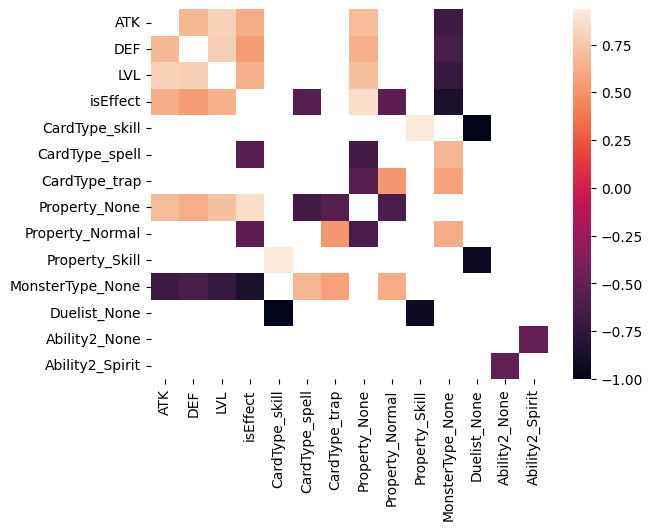

In [22]:
corr = model_data.corr(numeric_only=True)
corr = corr[(abs(corr) > 0.5) & (abs(corr) != 1)]
corr.dropna(axis=0, how='all', inplace=True)
corr.dropna(axis=1, how='all', inplace=True)
sns.heatmap(corr);

É possível notar que sim, existem diversas variáveis em que há presença de colinearidade. Essa informação será muito útil para a escolha das técnicas que serão utilizadas.

## Divisão dos dados

Antes de prosseguir para a seleção de um modelo e treinamento, é necessário dividir os dados em conjuntos de treinamento, validação e teste. O conjunto de treinamento é utilizado para treinar o modelo, o conjunto de validação é usado para ajustar os parâmetros do modelo e o conjunto de teste é utilizado para avaliar o desempenho final do modelo. Esta divisão é importante para evitar que a avaliação do modelo seja enviesada pelo resultado final, de forma a causar um "sobreajuste" para os dados de teste. 

In [23]:
X = model_data.drop(columns=["Price"]).values
y = model_data["Price"].values

In [24]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.25
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

In [25]:
print(f"X: {X.shape} \nx_train: {X_train.shape} \nx_valid: {X_valid.shape} \nx_test: {X_test.shape}")

X: (11563, 130) 
x_train: (6504, 130) 
x_valid: (2168, 130) 
x_test: (2891, 130)


In [26]:
print(f"y: {y.shape} \ny_train: {y_train.shape} \ny_valid: {y_valid.shape} \ny_test: {y_test.shape}")

y: (11563,) 
y_train: (6504,) 
y_valid: (2168,) 
y_test: (2891,)


## Modelo inicial de regressão linear

O modelo selecionado é a *regressão linear*, utilizando apenas *regularização* do tipo *Ridge*. O treinamento do modelo envolve a identificação dos coeficientes da equação linear que minimizam o erro entre as previsões do modelo e os valores reais disponíveis. A regularização, por sua vez, tem o objetivo de tratar problemas no cálculo dos coeficientes do modelo relativos à presença de variáveis colineares. Este mecanismo tenta equilibrar os coeficientes das features colineares, ou, em outras palavras, força um problema de otimização para uma solução “mais desejável” à priori.

### Regressão linear com regularização

In [27]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

### Avaliação do modelo

O desempenho do modelo é avaliado em relação ao subconjunto de validação. Para analisar este desempenho, será utilizada a métrica de Raiz do Erro Quadrático Médio (RMSE), que envolve  calcular a raiz quadrada do Erro Quadrático Médio (MSE). Esta métrica foi escolhida porque ela eleva ao quadrado os erros antes de tirar a média, o que significa que os erros maiores têm um peso maior, de modo que o RMSE será especialmente grande se o modelo cometer erros grandes. Essa propriedade é especialmente interessante neste caso, porque há o interesse em evitar erros grandes, já que um mesmo tipo de carta tem uma faixa de valores que variam muito. Ainda, há a vantagem de ser uma métrica de fácil interpretação, já que o valor resultante está na mesma unidade da variável dependente.

In [28]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(y_valid, y_pred))

print(f"RMSE do modelo de regressão linear: {RMSE}")

RMSE do modelo de regressão linear: 24.901586501764523


### Proposta de modelo alternativo

Com base na avaliação do modelo, fica evidente que um modelo simples de regressão linear não entrega um bom desempenho. No entanto, antes de propor um modelo alternativo podemos analisar o gráfico de resíduos para esta regressão e, assim, tomar uma decisão mais precisa.

Text(0.5, 1.0, 'Residual Plot')

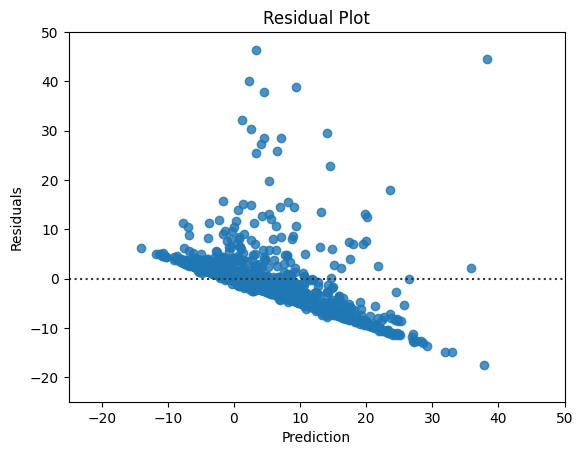

In [29]:
residual = (y_valid - y_pred)
sns.residplot(x=y_pred, y=residual)
plt.xlim(-25, 50)
plt.ylim(-25, 50)
plt.xlabel("Prediction")
plt.ylabel("Residuals")
plt.title("Residual Plot")

É interessante notar que, apesar de muitos valores estarem próximos do previsto pelo modelo, existem alguns valores que distoam muito.

## Proposta alternativa de modelo - SVR

A fim de lidar com esses *outliers*, a ideia é partir para uma abordagem diferente: *Support Vector Regression*. O *SVR* é uma adaptação do modelo de classificação *Support Vector Machines* (*SVM*) para problemas de regressão. 

Assim como a *SVM*, o *SVR* tenta encontrar o melhor hiperplano que se ajuste aos dados, mas com uma abordagem ligeiramente diferente. Em vez de tentar ajustar a maior margem entre duas classes como na SVM, o SVR tenta ajustar uma linha aos dados de tal maneira que a maior quantidade de pontos possíveis estejam dentro de um certo limite em torno dessa linha. Em outras palavras, o SVR tenta minimizar a quantidade de erro dentro desse limite, dado por um hiperparâmetro $\epsilon$ (*epsilon*) e considera apenas erros que estão fora do limite.

Além do mais, é importante utilizar uma técnica de estandardizar os dados, de forma que o algoritmo, que tem o objetivo de incluir o máximo de dados dentro do limite de $\epsilon$, conseguirá desempenhar sua função com melhor desempenho.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
model = LinearSVR(epsilon=0.1, C=1e-3, random_state=RANDOM_STATE)

pipe = Pipeline([
    ("scaler", scaler),
    ('model', model),
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)

### Avaliação do modelo

In [31]:
RMSE = np.sqrt(mean_squared_error(y_valid, y_pred))

print(f"RMSE do modelo de regressão SVR: {RMSE}")

RMSE do modelo de regressão SVR: 24.867425298419068


Text(0.5, 1.0, 'Residual Plot')

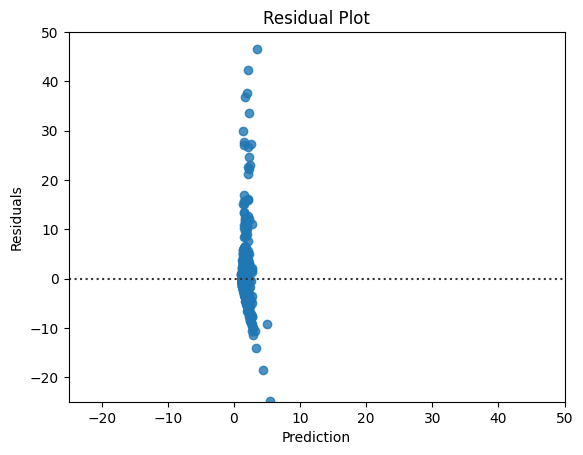

In [32]:
residual = (y_valid - y_pred)
sns.residplot(x=y_pred, y=residual)
plt.xlim(-25, 50)
plt.ylim(-25, 50)
plt.xlabel("Prediction")
plt.ylabel("Residuals")
plt.title("Residual Plot")

## Redefinição da abordagem do problema

Pode ser observado que, independentemente do modelo utilizado, se obteve um desempenho ruim para a previsão do preço. Analisando cada passo realizado até este momento, nota-se que um fato não foi levado em conta: os *tipos das cartas*. Até o momento, todos os tipos de cartas foram considerados como meras variáveis para o modelo, mas, talvez, os tipos sejam muito mais importantes que isso.

Portanto, considerando tudo que foi descoberto até agora, surge uma necessidade de mudar a abordagem aos dados. Neste momento, os dados das cartas serão divididas de acordo com o tipo da carta, a fim de que cada um gere um modelo indpendente dos outros.

In [30]:
model_data_spell = model_data[model_data["CardType_spell"] == 1].copy()
model_data_trap = model_data[model_data["CardType_trap"] == 1].copy()
model_data_skill = model_data[model_data["CardType_skill"] == 1].copy()
model_data_monster = model_data[(model_data["CardType_spell"] == 0) & (model_data["CardType_trap"] == 0) & (model_data["CardType_skill"] == 0)].copy()

all_model_data = {
    "Monster Card Type Data": model_data_monster,
    "Spell Card Type Data": model_data_spell,
    "Trap Card Type Data": model_data_trap,
    "Skill Card Type Data": model_data_skill
}

In [31]:
for data in all_model_data.items():
    data[1].drop(columns=["CardType_spell", "CardType_trap", "CardType_skill"], inplace=True)
    print(f"{data[0]}: {data[1].shape}")

Monster Card Type Data: (7467, 128)
Spell Card Type Data: (2258, 128)
Trap Card Type Data: (1736, 128)
Skill Card Type Data: (102, 128)


Infelizmente, ao realizar esta divisão, as cartas do tipo "Skill" são muito pouco representativas nos dados. Desta forma, por falta de dados, a melhor opção é descartar este subconjunto. 

In [32]:
del all_model_data["Skill Card Type Data"]

## Aplicando modelo para cada conjunto de dados

Repetindo o processo realizado anteriormente, primeiro será aplicado o modelo de regressão linear com regularização Ridge para cada um dos subconjuntos de dados separados na etapa anterior. 

RMSE do modelo de regressão linear para Monster Card Type Data: 29.98884719535681
RMSE do modelo de regressão linear para Spell Card Type Data: 4.2590491096645575
RMSE do modelo de regressão linear para Trap Card Type Data: 2.6491689370823504


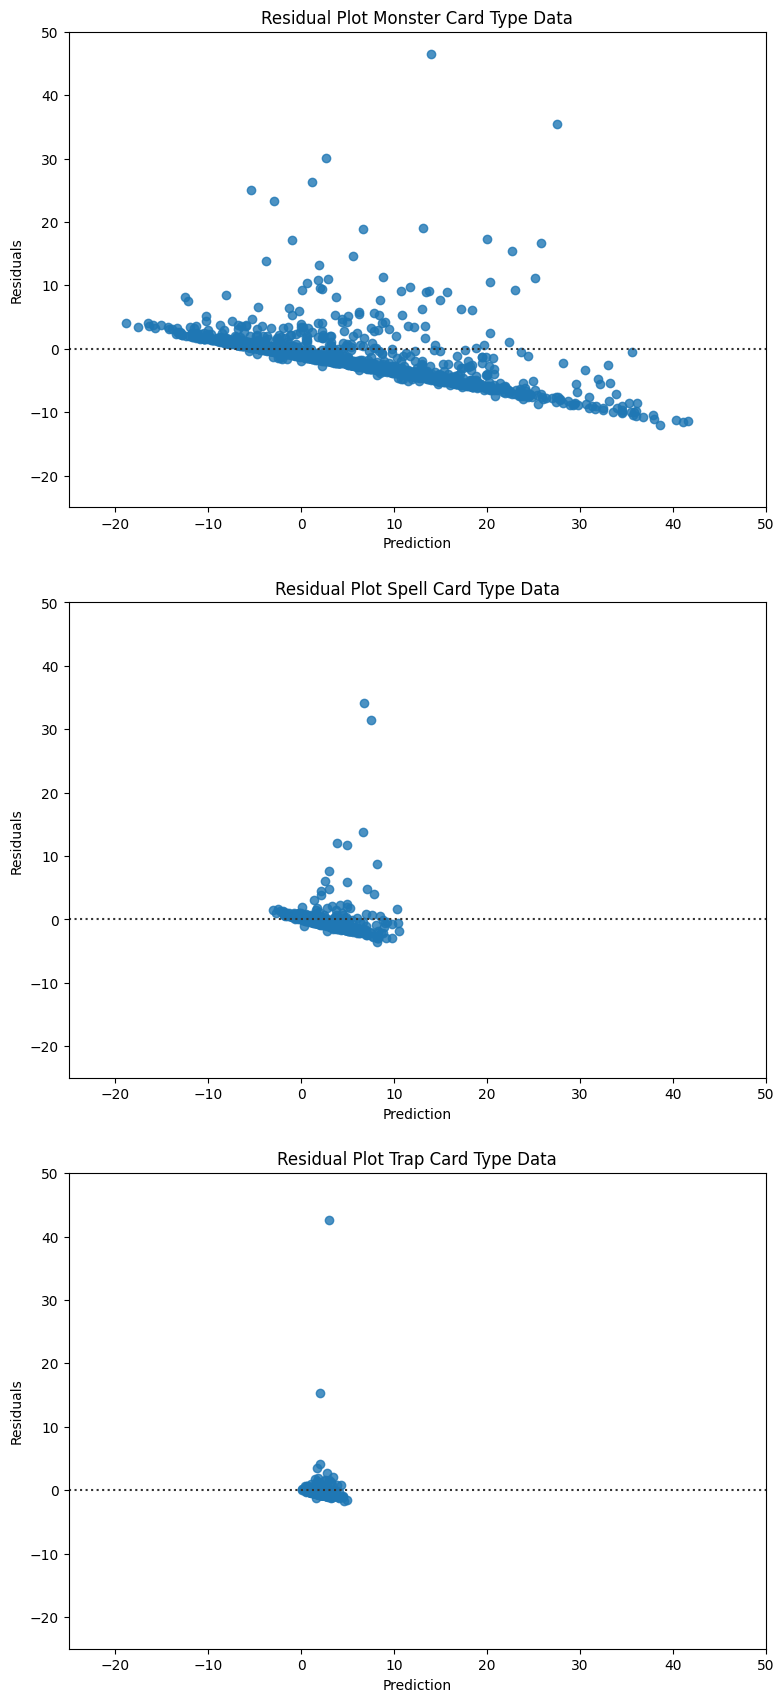

In [33]:
ALPHA = 1
subplot_idx = 311
plt.figure(figsize=(9, 21))

for data_name, data in all_model_data.items():
    X = data.drop(columns=["Price"]).values
    y = data["Price"].values

    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
    )

    model = Ridge(alpha=ALPHA)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    RMSE = np.sqrt(mean_squared_error(y_valid, y_pred))

    print(f"RMSE do modelo de regressão linear para {data_name}: {RMSE}")

    residual = (y_valid - y_pred)
    plt.subplot(subplot_idx)
    sns.residplot(x=y_pred, y=residual)
    plt.xlim(-25, 50)
    plt.ylim(-25, 50)
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {data_name}")
    subplot_idx += 1

plt.show()

Novamente, 

RMSE do modelo de SVR para Monster Card Type Data: 29.149576526899228
RMSE do modelo de SVR para Spell Card Type Data: 4.540613448842737
RMSE do modelo de SVR para Trap Card Type Data: 3.152343973772648


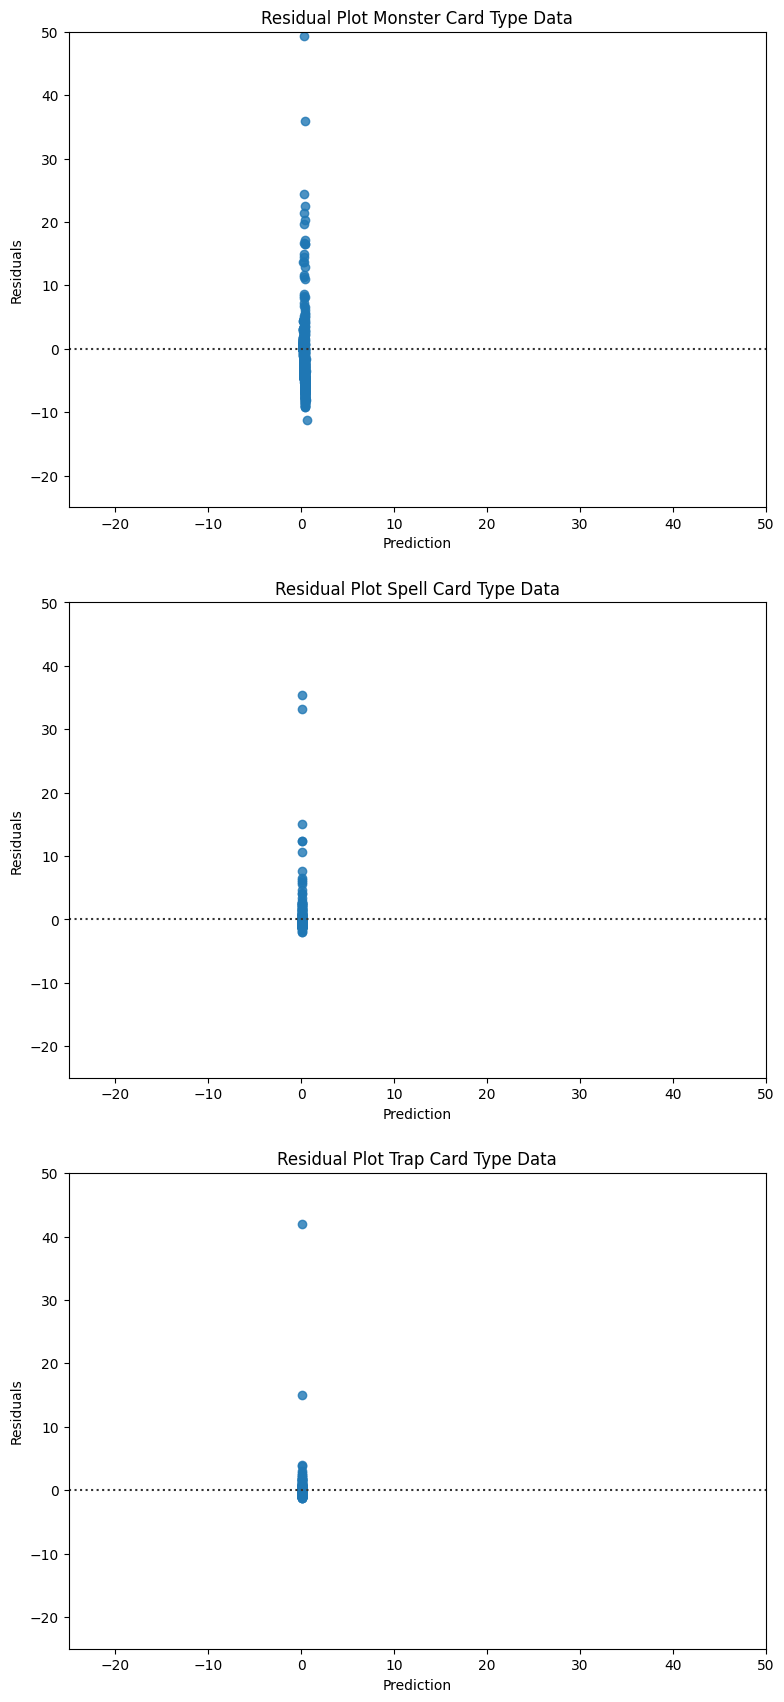

In [37]:
EPSILON = 1
C = 1e-4
subplot_idx = 311
plt.figure(figsize=(9, 21))

for data_name, data in all_model_data.items():
    X = data.drop(columns=["Price"]).values
    y = data["Price"].values

    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
    )

    scaler = StandardScaler()
    model = LinearSVR(epsilon=EPSILON, C=C, random_state=RANDOM_STATE)

    pipe = Pipeline([
        ("scaler", scaler),
        ('model', model),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)

    RMSE = np.sqrt(mean_squared_error(y_valid, y_pred))

    print(f"RMSE do modelo de SVR para {data_name}: {RMSE}")

    residual = (y_valid - y_pred)
    plt.subplot(subplot_idx)
    sns.residplot(x=y_pred, y=residual)
    plt.xlim(-25, 50)
    plt.ylim(-25, 50)
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {data_name}")
    subplot_idx += 1

plt.show()

RMSE do modelo de ElasticNet para Monster Card Type Data: 28.833527048923848
RMSE do modelo de ElasticNet para Spell Card Type Data: 4.032268078581207
RMSE do modelo de ElasticNet para Trap Card Type Data: 2.615687534216093


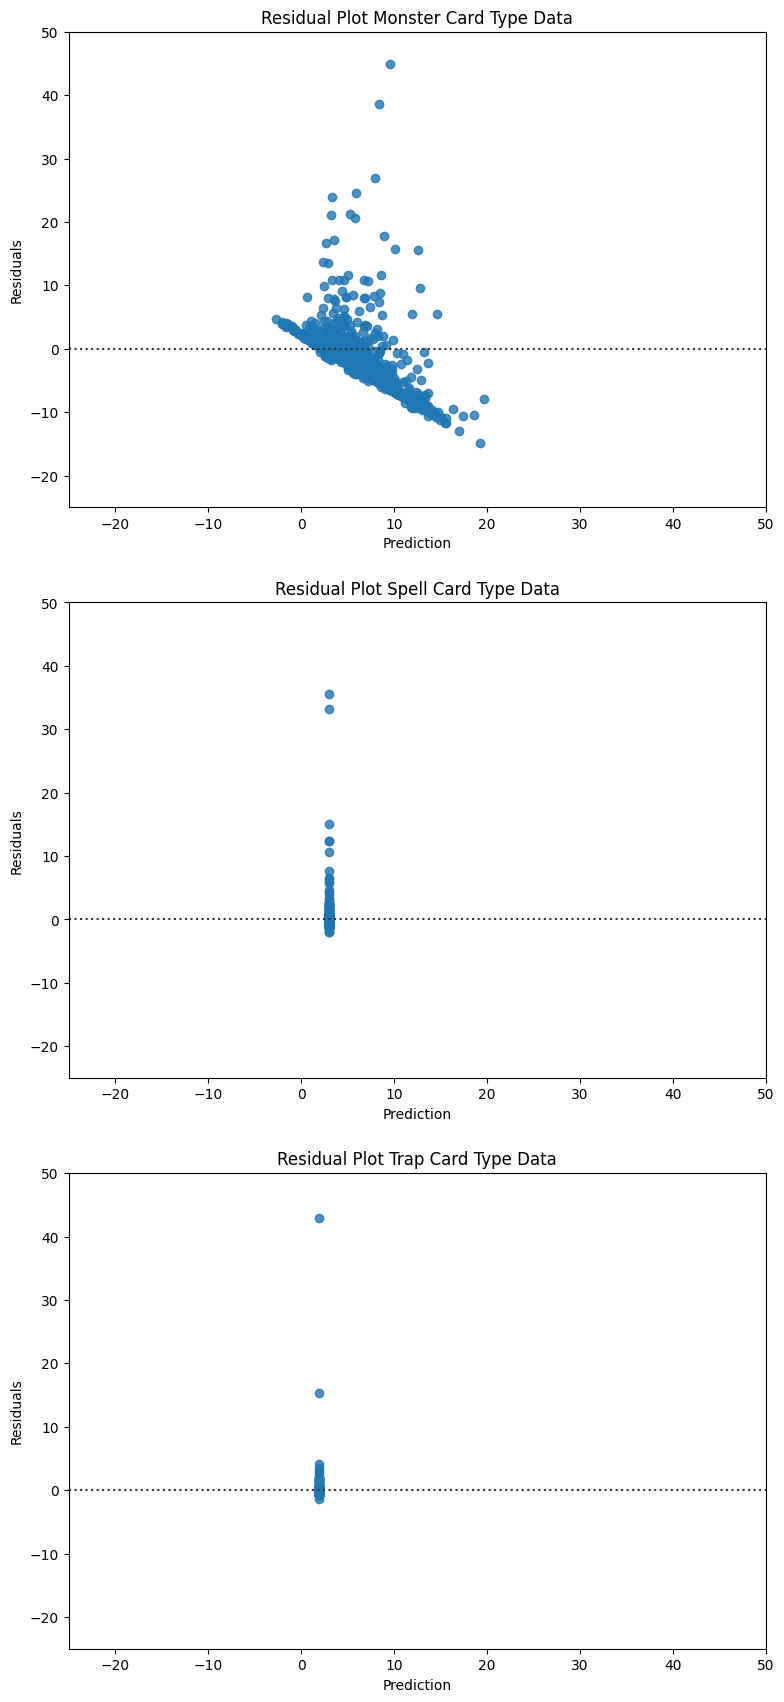

In [40]:
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, RidgeCV, LassoLars
from sklearn.pipeline import Pipeline

subplot_idx = 311
plt.figure(figsize=(9, 21))

for data_name, data in all_model_data.items():
    X = data.drop(columns=["Price"]).values
    y = data["Price"].values

    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
    )

    model = LassoLars()

    pipe = Pipeline([
        ('model', model),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)

    RMSE = np.sqrt(mean_squared_error(y_valid, y_pred))

    print(f"RMSE do modelo de ElasticNet para {data_name}: {RMSE}")

    residual = (y_valid - y_pred)
    plt.subplot(subplot_idx)
    sns.residplot(x=y_pred, y=residual)
    plt.xlim(-25, 50)
    plt.ylim(-25, 50)
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {data_name}")
    subplot_idx += 1

plt.show()

In [44]:
for i in all_model_data["Spell Card Type Data"].columns:
    print(i)

# - **Monster**: Possui *Attribute*, *ATK*, *DEF*, *LVL*, *MonsterType*, *isEffect*, *Ability1*, *Ability2*, *isTuner* e *isPendulum*;
# - **Spell**: Possui apenas *Property*;
# - **Trap**: Possui apenas *Property*;
# - **Skill**: Possui *Property* e *Duelist*;

Price
ATK
DEF
LVL
isEffect
isTuner
isPendulum
Rarity_Collector's Rare
Rarity_Collectors Rare
Rarity_Common
Rarity_Duel Terminal Normal Parallel Rare
Rarity_Duel Terminal Super Parallel Rare
Rarity_Duel Terminal Ultra Parallel Rare
Rarity_Gold Rare
Rarity_Gold Secret Rare
Rarity_Mosaic Rare
Rarity_Platinum Rare
Rarity_Platinum Secret Rare
Rarity_Premium Gold Rare
Rarity_Prismatic Secret Rare
Rarity_Rare
Rarity_Secret Rare
Rarity_Shatterfoil Rare
Rarity_Short Print
Rarity_Starfoil Rare
Rarity_Super Rare
Rarity_Super Short Print
Rarity_Ultimate Rare
Rarity_Ultra Rare
Attribute_dark
Attribute_divine
Attribute_earth
Attribute_fire
Attribute_light
Attribute_water
Attribute_wind
Property_Continuous Spell
Property_Continuous Trap
Property_Counter
Property_Equip
Property_Field
Property_Field Spell
Property_None
Property_Normal
Property_Quick-Play
Property_Ritual
Property_Skill
MonsterType_Beast
MonsterType_Beast-Warrior
MonsterType_Cyberse
MonsterType_Dinosaur
MonsterType_Divine-Beast
MonsterTy

### Teste do modelo

O modelo ajustado é então testado usando o conjunto de teste, que contém dados não vistos anteriormente. Isso permite avaliar como o modelo se comporta em situações reais e verificar sua capacidade de generalização.